## Import libraries

In [1]:
# system and performance
import gc
import time
import os
import pickle


# date management
import datetime
import calendar


# data management
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

from itertools import product

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# machine learning
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
def create_directory(path):
    if not os.path.isdir(path):
        os.mkdir(path)
        print('directory '+path+' created succesfully !')
    else:
        print('directory '+path+' already exists')

In [3]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [4]:
# path to data
RAW_DATA_FOLDER = '../data/raw/'
DATA_FOLDER = '../data/'

##### Define core variable space and macro to reset variable space

In [5]:
loaded=%who_ls
loaded.append('loaded')

In [6]:
all_vars=%who_ls
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var

In [7]:
%macro reset_variable_space 6
loaded.append('reset_variable_space')

Macro `reset_variable_space` created. To execute, type its name (without quotes).
=== Macro contents: ===
all_vars=get_ipython().run_line_magic('who_ls', '')
all_vars.append('all_vars')
for var in list(set(all_vars)-set(loaded)):
    exec('del '+var)
del var
 

## -------------------------------------------------------------

# 5 - VALIDATION

## Functions for training and validation

In [8]:
# SPLIT TRAIN-VALIDATION SET
def datasplit_train_val(train_df,n_months_val=1,month_id_first=0):
    if month_id_first==0:
        month_id_first=train_df['month_id'].min()
        
    month_id_split=train_df['month_id'].max()-(n_months_val-1)

    # TRAINING SET
    X_train=train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<month_id_split),:].astype(np.float32)
    Y_train=X_train['item_quantity'].astype(np.float32)
    X_train.drop(['month_id','item_quantity'],axis=1,inplace=True)

    print(X_train.shape, Y_train.shape)

    # VALIDATION SET
    X_val=train_df.loc[train_df['month_id']>=month_id_split,:].astype(np.float32)
    Y_val=X_val['item_quantity'].astype(np.float32)
    X_val.drop(['month_id','item_quantity'],axis=1,inplace=True)

    print(X_val.shape , Y_val.shape)

    return (X_train,Y_train,X_val,Y_val)





# SPLIT TRAINING SET MONTH BY MONTH
def datasplit_evalset(train_df,month_id_first=0):
    if month_id_first==0:
        month_id_first=train_df['month_id'].min()
        
    eval_set=[]
    for mid in train_df['month_id'].unique():
        if (mid>=month_id_first)&(mid<34):
            X_val=train_df.loc[(train_df['month_id']==mid),:].astype(np.float32)
            Y_val=X_val['item_quantity'].astype(np.float32)
            X_val.drop(['month_id','item_quantity'],axis=1,inplace=True)
            eval_set.append((X_val,Y_val))
        
    return eval_set

In [9]:
# ANALYSIS OF CORRELATIONS OF FEATURES WITH TARGET
def show_feature_target_correlations(train_df,month_id_first=22,clip_value=20):
    n_features=len(train_df.columns)-1
    
    train_clip=train_df.copy()
    train_clip['item_quantity'].clip(0,clip_value,inplace=True)

    # plot month by month correlations
    fig,ax=plt.subplots(1,1,figsize=(15,np.floor(n_features/3)))
    for i in range(month_id_first,34):
        tmp=train_clip.loc[train_clip['month_id']==i,:].corr()
        tmp.drop('item_quantity',axis=0,inplace=True)
        ax.plot(tmp['item_quantity'],tmp.index,'x')
    ax.grid(True)

    # plot global correlation over all months
    tmp=train_clip.loc[train_clip['month_id']>=month_id_first,:].corr()
    tmp.drop('item_quantity',axis=0,inplace=True)
    ax.plot(tmp['item_quantity'],tmp.index,'ko',markersize=10)

In [10]:
# ANALYSIS OF TARGET VALUE AND NAIVE PREDICTIONS
def target_analysis_val(train_df,n_months_val=1,month_id_first=0):

    # split dataset
    (X_train,Y_train,X_val,Y_val) = datasplit_train_val(train_df,n_months_val,month_id_first)
    evalset = datasplit_evalset(train_df,month_id_first)

    # TRAINING SET
    base_score=Y_train.mean()
    
    Y_guess_train=0*Y_train
    rmse_guess_train=np.sqrt(mean_squared_error(Y_train, Y_guess_train))

    Y_base_train=0*Y_train+base_score
    rmse_base_train=np.sqrt(mean_squared_error(Y_train, Y_base_train))

    print('#### TRAINING SET ###')
    print('mean target value: '+str(base_score))
    print('RMSE (guess,base): '+str(rmse_guess_train)+' , '+str(rmse_base_train))

    
    # VALIDATION SET
    base_score_val=Y_val.mean()
    
    Y_guess_val=0*Y_val 
    rmse_guess_val=np.sqrt(mean_squared_error(Y_val, Y_guess_val))

    Y_base_val=0*Y_val+base_score_val
    rmse_base_val=np.sqrt(mean_squared_error(Y_val, Y_base_val))

    print('#### VALIDATION SET ###')
    print('mean target value: '+str(base_score_val))
    print('RMSE (guess,base): '+str(rmse_guess_val)+' , '+str(rmse_base_val))
    

    # EVALUATION SET
    base_score_evalset=[Y.mean() for (_,Y) in evalset]

    rmse_guess_evalset=[]
    rmse_base_evalset=[]
    for (_,Y) in evalset:
        Y_guess=0*Y
        rmse_guess_evalset.append(np.sqrt(mean_squared_error(Y, Y_guess)))

        Y_base=0*Y+Y.mean()
        rmse_base_evalset.append(np.sqrt(mean_squared_error(Y, Y_base)))

    print('#### EVAL SET ###')
    print('mean target value: '+str([round(b*1e4)/1e4 for b in base_score_evalset]))
    print('RMSE (guess): '+str([round(b*1e2)/1e2 for b in rmse_guess_evalset]))
    print('RMSE (base): '+str([round(b*1e2)/1e2 for b in rmse_base_evalset]))

    
    
    # DISPLAY
    fig,axes=plt.subplots(1,2,figsize=(15,5))
    axes[0].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),base_score_evalset,'-o')
    axes[0].set_xlabel('month_id')
    axes[0].set_ylabel('mean of target value')
    axes[0].grid(True)
    axes[0].set_ylim(bottom=0)

    axes[1].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),rmse_guess_evalset,'-o')
    axes[1].plot(train_df.loc[(train_df['month_id']>=month_id_first)&(train_df['month_id']<34),'month_id'].unique(),rmse_base_evalset,'-o')
    axes[1].set_xlabel('month_id')
    axes[1].set_ylabel('rmse')
    axes[1].legend(['guess = 0','mean value'])
    axes[1].grid(True)
    axes[1].set_ylim(bottom=0)
                             
    return rmse_guess_train, rmse_base_train, rmse_guess_val, rmse_base_val, rmse_guess_evalset, rmse_base_evalset

In [11]:
# PERFORMANCES ON TRAINING SET
def performance_analysis_val(xgbreg,rmse_guess_train,rmse_base_train,rmse_guess_val,rmse_base_val,rmse_guess_evalset,rmse_base_evalset):

    rmse_evalset_last=[]
    rmse_evalset_min=[]
    for evset in xgbreg.evals_result().values():
        rmse_evalset_last.append(evset['rmse'][-1])
        rmse_evalset_min.append(min(evset['rmse']))

    # display
    print('#### TRAINING SET ###')
    print('RMSE (last, min, base, guess): '+str(rmse_evalset_last[0]) +' , '+str(rmse_evalset_min[0])+' , '+str(rmse_base_train)+' , '+str(rmse_guess_train))
    print()
    print('#### VALIDATION SET ###')
    print('RMSE (last, min, base, guess): '+str(rmse_evalset_last[1]) +' , '+str(rmse_evalset_min[1])+' , '+str(rmse_base_val)+' , '+str(rmse_guess_val))
    print()
    print('#### EVAL SET ###')
    print('RMSE (last): '+str([round(b*1e4)/1e4 for b in rmse_evalset_last[2:]]))
    print('RMSE (min): '+str([round(b*1e4)/1e4 for b in rmse_evalset_min[2:]]))
    print('RMSE (guess): '+str([round(b*1e4)/1e4 for b in rmse_guess_evalset]))
    print('RMSE (base): '+str([round(b*1e4)/1e4 for b in rmse_base_evalset]))


    fig,axes=plt.subplots(1,2,figsize=(15,5))
    for i in range(2,len(xgbreg.evals_result())):
        evset=xgbreg.evals_result()['validation_'+str(i)]['rmse']
        axes[0].plot(evset,'-o')
    axes[0].legend(range(0,len(eval_set)))
    axes[0].plot(xgbreg.evals_result()['validation_0']['rmse'],'k',linewidth=5)
    axes[0].plot(xgbreg.evals_result()['validation_1']['rmse'],'k--',linewidth=5)


    axes[1].plot(rmse_evalset_last[2:],'-o')
    axes[1].plot(0*np.array(rmse_evalset_last[2:])+rmse_evalset_last[0],'k')
    axes[1].plot(0*np.array(rmse_evalset_last[2:])+rmse_evalset_last[1],'k--')
    axes[1].plot(rmse_evalset_min[2:],'-o')
    axes[1].plot(0*np.array(rmse_evalset_min[2:])+rmse_evalset_last[0],'r')
    axes[1].plot(0*np.array(rmse_evalset_min[2:])+rmse_evalset_last[1],'r--')
    axes[1].plot(rmse_guess_evalset,'k-s')
    axes[1].set_xlabel('month_id')
    axes[1].set_ylabel('rmse (last,min)')
    axes[1].grid(True)
    axes[1].set_ylim(bottom=0)

In [12]:
# PLOT LEARNING CURVES
def learning_curves(xgbreg,n_months_val,month_id_first):
    n_sets=len(xgbreg.evals_result())-2
    ntrees=xgbreg.get_num_boosting_rounds()
    
    fig,axes=plt.subplots(2,2,figsize=(15,10))
    axes[0,0].plot(xgbreg.evals_result()['validation_1']['rmse'])
    for i in range(0,n_months_val):
        axes[0,0].plot(xgbreg.evals_result()['validation_'+str(n_sets+i)]['rmse'])
    axes[0,0].set_xlim(0,ntrees)
    axes[0,0].grid(True)
    axes[0,0].set_title('validation')

    axes[0,1].plot(xgbreg.evals_result()['validation_1']['rmse'],label='validation')
    for i in range(0,n_months_val):
        axes[0,1].plot(xgbreg.evals_result()['validation_'+str(n_sets+i)]['rmse'],label='month '+str(month_id_first+n_sets+i-2))
    axes[0,1].set_xlim(0,ntrees)
    axes[0,1].grid(True)
    axes[0,1].legend()
    axes[0,1].set_title('validation')

    
    axes[1,0].plot(xgbreg.evals_result()['validation_0']['rmse'],'k',linewidth=3)
    for i in range(2,n_sets):
        axes[1,0].plot(xgbreg.evals_result()['validation_'+str(i)]['rmse'])
    axes[1,0].set_xlim(0,ntrees)
    axes[1,0].grid(True)
    axes[1,0].set_title('training')

    
    axes[1,1].plot(xgbreg.evals_result()['validation_0']['rmse'],'k',linewidth=3,label='training')
    for i in range(2,n_sets):
        axes[1,1].plot(xgbreg.evals_result()['validation_'+str(i)]['rmse'],label='month '+str(month_id_first+i-2))
    axes[1,1].set_xlim(0,ntrees)
    axes[1,1].grid(True)
    axes[1,1].legend()
    axes[1,1].set_title('training')
    
    return axes

In [13]:
# FEATURE IMPORTANCE
def plot_feature_importance(xgbreg,X_train):
    # gain     := improvement in accuracy resulting from a split according to this feature (measured by a reduction of the optimization metric)
    # weight   := number of times a feature is used to split the data across all trees
    # coverage := number of observations that are classified according to this feature in the tree

    n_features=len(X_train.columns)
    
    fi_types=[ 'total_gain' , 'gain', 'weight', 'cover' , 'total_cover']
    xgb_fi=pd.DataFrame(index=X_train.columns)
    for typ in fi_types:
        xgb_fi[typ]=pd.Series(data=xgbreg.get_booster().get_score(importance_type=typ),index=X_train.columns)

    xgb_fi.fillna(0,inplace=True)
    xgb_fi=xgb_fi.sort_values(by='gain',ascending=True)

    fig,ax=plt.subplots(1,5,figsize=(18,np.floor(n_features/2.5)))
    for i,typ in enumerate(fi_types[0:5]):
        if i==0:
            ax[i].barh(y=xgb_fi.index,width=xgb_fi[typ].values)
        else:
            ax[i].barh(y=xgb_fi.index,width=xgb_fi[typ].values,tick_label=[None])
        ax[i].grid(True)
        ax[i].set_title(typ)

In [14]:
loaded=%who_ls
loaded.append('loaded')

## ----------------------------------------------

## SENIORITY 2

### Import and process training set

In [15]:
dataset_name='train_2_pred'
n_months_val=2
month_id_first=18

train_X=pd.read_pickle(os.path.join(DATA_FOLDER,'training/'+dataset_name+'.pkl'))

# drop test set for validation purposes
train_X.drop(train_X.loc[train_X['month_id']==34].index,axis=0,inplace=True)

print(train_X.info(null_counts=True,verbose=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3398863 entries, 4463079 to 10681411
Data columns (total 145 columns):
month_id                                                                               3398863 non-null int8
item_category_id                                                                       3398863 non-null int8
item_quantity                                                                          3398863 non-null float32
shop_months_since_opening                                                              3398863 non-null int8
item_freq_in_seniority                                                                 3398863 non-null float32
item_category_freq                                                                     3398863 non-null float32
item_supercategory_freq                                                                3398863 non-null float32
item_category_console_freq                                                             3398863 non-null 

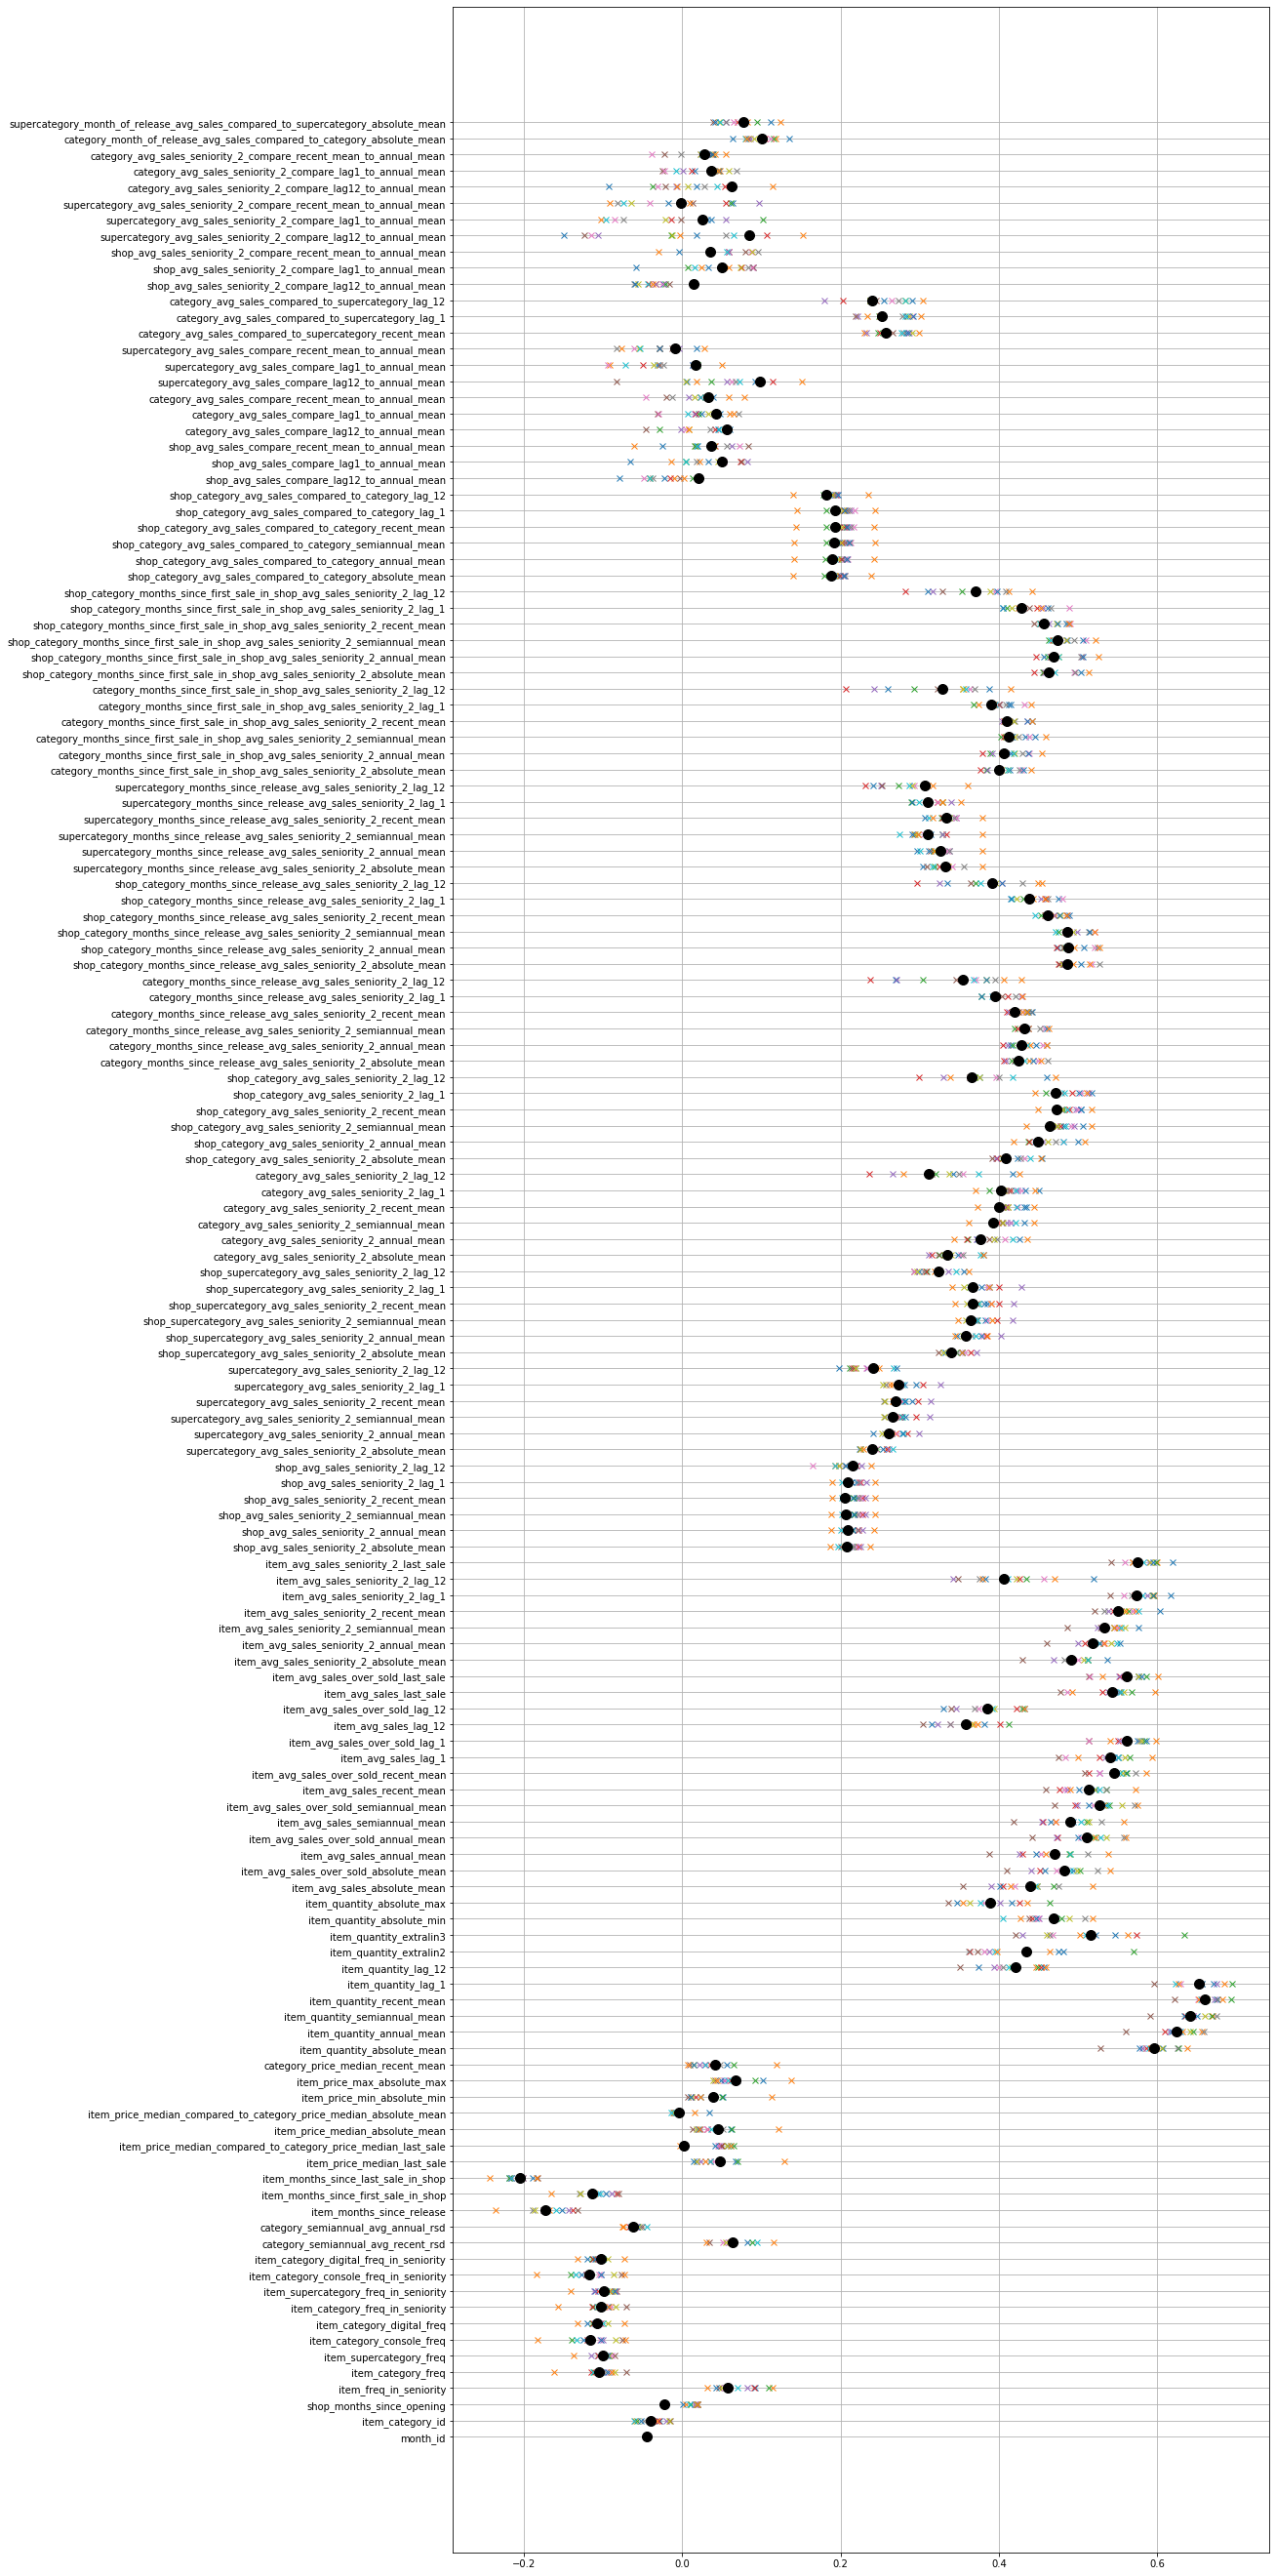

In [16]:
# analyse correlation of features with target variable
show_feature_target_correlations(train_X,month_id_first=22)

(2119203, 143) (2119203,)
(234703, 143) (234703,)
#### TRAINING SET ###
mean target value: 0.4388159215450287
RMSE (guess,base): 1.4526887 , 1.3848268014666387
#### VALIDATION SET ###
mean target value: 0.3744732737541199
RMSE (guess,base): 1.2575215 , 1.2004707585130476
#### EVAL SET ###
mean target value: [0.4062, 0.4639, 0.3864, 0.4126, 0.4346, 0.7168, 0.5459, 0.4255, 0.409, 0.3427, 0.3575, 0.3778, 0.3875, 0.425, 0.3729, 0.3761]
RMSE (guess): [1.32, 1.52, 1.29, 1.45, 1.44, 2.18, 1.72, 1.36, 1.31, 1.23, 1.2, 1.28, 1.26, 1.31, 1.25, 1.26]
RMSE (base): [1.26, 1.45, 1.23, 1.39, 1.37, 2.06, 1.64, 1.29, 1.24, 1.18, 1.14, 1.22, 1.2, 1.24, 1.2, 1.2]


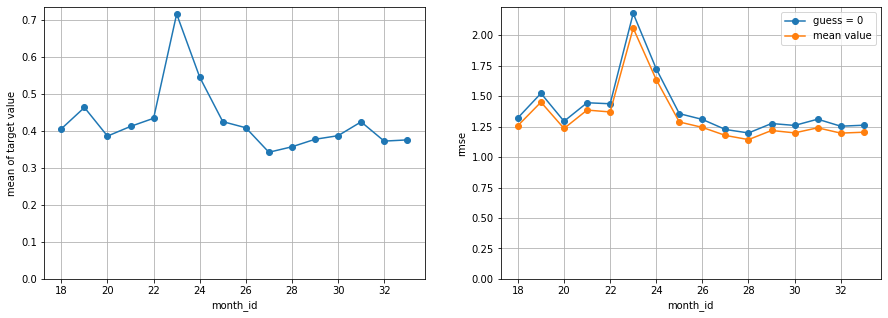

In [17]:
# analyse target value
rmse_guess_train, rmse_base_train, rmse_guess_val, rmse_base_val, rmse_guess_evalset, rmse_base_evalset = target_analysis_val(train_X,n_months_val=2,month_id_first=18)

In [18]:
features_to_keep_2=[]

#--------------
# CATEGORY
features_to_keep_2+=['item_category_id']                                      

features_to_keep_2+=['item_category_freq']                                    
features_to_keep_2+=['item_supercategory_freq']                               
features_to_keep_2+=['item_category_console_freq']                            
#features_to_keep_2+=['item_category_digital_freq']

#features_to_keep_2+=['item_category_freq_in_seniority']
#features_to_keep_2+=['item_supercategory_freq_in_seniority']
#features_to_keep_2+=['item_category_console_freq_in_seniority']
#features_to_keep_2+=['item_category_digital_freq_in_seniority']

features_to_keep_2+=['category_semiannual_avg_recent_rsd']
features_to_keep_2+=['category_semiannual_avg_annual_rsd']


#--------------
# SHOP
features_to_keep_2+=['shop_months_since_opening']

#--------------
# ITEM
#features_to_keep_2+=['item_freq_in_seniority']

#--------------
# RELATIVE TIME FEATURES
features_to_keep_2+=['item_months_since_release']
features_to_keep_2+=['item_months_since_first_sale_in_shop']
features_to_keep_2+=['item_months_since_last_sale_in_shop']










#--------------
# PRICES

features_to_keep_2+=['item_price_median_absolute_mean']                
features_to_keep_2+=['item_price_median_last_sale']                    
features_to_keep_2+=['item_price_min_absolute_min']                    
features_to_keep_2+=['item_price_max_absolute_max']                    

features_to_keep_2+=['item_price_median_compared_to_category_price_median_absolute_mean']                
features_to_keep_2+=['item_price_median_compared_to_category_price_median_last_sale']                    

features_to_keep_2+=['category_price_median_recent_mean']                    










#--------------
# SHOP-ITEM
#features_to_keep_2+=['item_quantity_absolute_mean']
features_to_keep_2+=['item_quantity_annual_mean']                    
features_to_keep_2+=['item_quantity_semiannual_mean']                
features_to_keep_2+=['item_quantity_recent_mean']                    
features_to_keep_2+=['item_quantity_lag_1']                          
features_to_keep_2+=['item_quantity_lag_12']                         

features_to_keep_2+=['item_quantity_extralin2']                       
features_to_keep_2+=['item_quantity_extralin3']    

features_to_keep_2+=['item_quantity_absolute_min']                    
features_to_keep_2+=['item_quantity_absolute_max']                    

#--------------
# ITEM
#features_to_keep_2+=['item_avg_sales_absolute_mean']
#features_to_keep_2+=['item_avg_sales_annual_mean']
#features_to_keep_2+=['item_avg_sales_semiannual_mean']
features_to_keep_2+=['item_avg_sales_recent_mean']                  
features_to_keep_2+=['item_avg_sales_lag_1']                        
#features_to_keep_2+=['item_avg_sales_lag_12']
features_to_keep_2+=['item_avg_sales_last_sale']                    


#features_to_keep_2+=['item_avg_sales_over_sold_absolute_mean']
#features_to_keep_2+=['item_avg_sales_over_sold_annual_mean']
#features_to_keep_2+=['item_avg_sales_over_sold_semiannual_mean']
features_to_keep_2+=['item_avg_sales_over_sold_recent_mean']                    
features_to_keep_2+=['item_avg_sales_over_sold_lag_1']                          
features_to_keep_2+=['item_avg_sales_over_sold_lag_12']                         
features_to_keep_2+=['item_avg_sales_over_sold_last_sale']                      


#features_to_keep_2+=['item_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['item_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['item_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['item_avg_sales_seniority_2_recent_mean']
#features_to_keep_2+=['item_avg_sales_seniority_2_lag_1']
#features_to_keep_2+=['item_avg_sales_seniority_2_lag_12']
#features_to_keep_2+=['item_avg_sales_seniority_2_last_sale']



#--------------
# SHOP
#features_to_keep_2+=['shop_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_recent_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_lag_1']
features_to_keep_2+=['shop_avg_sales_seniority_2_lag_12']                                             
                                                                    
#--------------
# SUPERCATEGORY
#features_to_keep_2+=['supercategory_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['supercategory_avg_sales_seniority_2_annual_mean']                
#features_to_keep_2+=['supercategory_avg_sales_seniority_2_semiannual_mean']
features_to_keep_2+=['supercategory_avg_sales_seniority_2_recent_mean']               
features_to_keep_2+=['supercategory_avg_sales_seniority_2_lag_1']                     
features_to_keep_2+=['supercategory_avg_sales_seniority_2_lag_12']                       

#--------------
# SHOP-SUPERCATEGORY
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_annual_mean']                            
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_recent_mean']                              
#features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_lag_1']                                    
features_to_keep_2+=['shop_supercategory_avg_sales_seniority_2_lag_12']                                   

#--------------
# CATEGORY
#features_to_keep_2+=['category_avg_sales_seniority_2_absolute_mean']
features_to_keep_2+=['category_avg_sales_seniority_2_annual_mean']             
features_to_keep_2+=['category_avg_sales_seniority_2_semiannual_mean']             
features_to_keep_2+=['category_avg_sales_seniority_2_recent_mean']                   
features_to_keep_2+=['category_avg_sales_seniority_2_lag_1']                    
#features_to_keep_2+=['category_avg_sales_seniority_2_lag_12']                      

#--------------
# SHOP-CATEGORY
#features_to_keep_2+=['shop_category_avg_sales_seniority_2_absolute_mean']
features_to_keep_2+=['shop_category_avg_sales_seniority_2_annual_mean']                                              
features_to_keep_2+=['shop_category_avg_sales_seniority_2_semiannual_mean']                                            
features_to_keep_2+=['shop_category_avg_sales_seniority_2_recent_mean']                                                
features_to_keep_2+=['shop_category_avg_sales_seniority_2_lag_1']                                                      
features_to_keep_2+=['shop_category_avg_sales_seniority_2_lag_12']                                                     
                  


    
    

#--------------
# MONTHS SINCE RELEASE
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_absolute_mean']         
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_semiannual_mean']
features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_recent_mean']              
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_lag_1']
#features_to_keep_2+=['category_months_since_release_avg_sales_seniority_2_lag_12']                  

features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_absolute_mean']                       
#features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_annual_mean'] 
#features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_recent_mean']                         
#features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_lag_1']               
features_to_keep_2+=['shop_category_months_since_release_avg_sales_seniority_2_lag_12']                               


#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_absolute_mean']
#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_recent_mean']
#features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_lag_1']
features_to_keep_2+=['supercategory_months_since_release_avg_sales_seniority_2_lag_12']                             


#--------------
# MONTHS SINCE FIRST SALE IN SHOP
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_absolute_mean']                
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_annual_mean']           
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_semiannual_mean']
features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_recent_mean']              
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_lag_1']                  
#features_to_keep_2+=['category_months_since_first_sale_in_shop_avg_sales_seniority_2_lag_12']                  

#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_absolute_mean']            
#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_annual_mean']
#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_semiannual_mean']
#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_recent_mean']               
#features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_lag_1']
features_to_keep_2+=['shop_category_months_since_first_sale_in_shop_avg_sales_seniority_2_lag_12']                



#--------------
# SPATIAL TRENDS
#features_to_keep_2+=['shop_category_avg_sales_compared_to_category_absolute_mean']
features_to_keep_2+=['shop_category_avg_sales_compared_to_category_annual_mean']              
#features_to_keep_2+=['shop_category_avg_sales_compared_to_category_semiannual_mean']
features_to_keep_2+=['shop_category_avg_sales_compared_to_category_recent_mean']            
#features_to_keep_2+=['shop_category_avg_sales_compared_to_category_lag_1']                  
#features_to_keep_2+=['shop_category_avg_sales_compared_to_category_lag_12']                


# TEMPORAL TRENDS
#features_to_keep_2+=['shop_avg_sales_compare_recent_mean_to_annual_mean']
#features_to_keep_2+=['shop_avg_sales_compare_lag1_to_annual_mean']                               
features_to_keep_2+=['shop_avg_sales_compare_lag12_to_annual_mean']                              

features_to_keep_2+=['supercategory_avg_sales_compare_recent_mean_to_annual_mean']         
#features_to_keep_2+=['supercategory_avg_sales_compare_lag1_to_annual_mean']
features_to_keep_2+=['supercategory_avg_sales_compare_lag12_to_annual_mean']               

features_to_keep_2+=['category_avg_sales_compare_recent_mean_to_annual_mean']            
#features_to_keep_2+=['category_avg_sales_compare_lag1_to_annual_mean']
features_to_keep_2+=['category_avg_sales_compare_lag12_to_annual_mean']                  

features_to_keep_2+=['category_avg_sales_compared_to_supercategory_recent_mean']           
#features_to_keep_2+=['category_avg_sales_compared_to_supercategory_lag_1']                
features_to_keep_2+=['category_avg_sales_compared_to_supercategory_lag_12']                      


# TEMPORAL TRENDS FOR SENIORITY 2 (months of the year where seniority 2 is boosted due to previous release of new items)
#features_to_keep_2+=['shop_avg_sales_seniority_2_compare_recent_mean_to_annual_mean']
#features_to_keep_2+=['shop_avg_sales_seniority_2_compare_lag1_to_annual_mean']                   
features_to_keep_2+=['shop_avg_sales_seniority_2_compare_lag12_to_annual_mean']                 

#features_to_keep_2+=['supercategory_avg_sales_seniority_2_compare_recent_mean_to_annual_mean']
#features_to_keep_2+=['supercategory_avg_sales_seniority_2_compare_lag1_to_annual_mean']
features_to_keep_2+=['supercategory_avg_sales_seniority_2_compare_lag12_to_annual_mean']         

#features_to_keep_2+=['category_avg_sales_seniority_2_compare_recent_mean_to_annual_mean']
#features_to_keep_2+=['category_avg_sales_seniority_2_compare_lag1_to_annual_mean']
features_to_keep_2+=['category_avg_sales_seniority_2_compare_lag12_to_annual_mean']              


# MONTH OF RELEASE
features_to_keep_2+=['supercategory_month_of_release_avg_sales_compared_to_supercategory_absolute_mean']          
features_to_keep_2+=['category_month_of_release_avg_sales_compared_to_category_absolute_mean']                    

In [19]:
# drop features
features_to_discard_2=list( set(list(train_X.columns)) - set(['month_id','item_quantity']+features_to_keep_2) )
train_X.drop(features_to_discard_2,axis=1,inplace=True)

# fill missing values
train_X['item_quantity_extralin2'].fillna(train_X['item_quantity_lag_1'],inplace=True)
train_X['item_quantity_extralin3'].fillna(train_X['item_quantity_lag_1'],inplace=True)
train_X.fillna(-1,inplace=True)

# split dataset
(X_train,Y_train,X_val,Y_val) = datasplit_train_val(train_X,n_months_val,month_id_first)
eval_set = [(X_train,Y_train),(X_val,Y_val)]+datasplit_evalset(train_X,month_id_first)

# show dataset info
print('number of features to keep : '+str(len(features_to_keep_2)))
print('number of features kept    : '+str(len(X_train.columns)))

print(X_train.info(null_counts=True,verbose=True))


# clear memory space
del train_X
gc.collect()

(2119203, 67) (2119203,)
(234703, 67) (234703,)
number of features to keep : 67
number of features kept    : 67
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2119203 entries, 6437735 to 10247249
Data columns (total 67 columns):
item_category_id                                                                    2119203 non-null float32
shop_months_since_opening                                                           2119203 non-null float32
item_category_freq                                                                  2119203 non-null float32
item_supercategory_freq                                                             2119203 non-null float32
item_category_console_freq                                                          2119203 non-null float32
category_semiannual_avg_recent_rsd                                                  2119203 non-null float32
category_semiannual_avg_annual_rsd                                                  2119203 non-null float32
item_

5643

### XGBRegressor - validation

In [20]:
# SET XGBOOST PARAMETERS

xgb_params_2={'objective':        'reg:squarederror',
# TREE SPECIFIC PARAMETERS
              'max_depth':        6,
              'min_child_weight': 300,
              'subsample':        0.8,
              'colsample_bytree': 0.8,
# PARAMETERS RELATED TO THE LEARNING/BOOSTING PROCESS
              'learning_rate':    0.02,
              'n_estimators':     2000,  
# MISCELLANEOUS PARAMETERS
              'base_score':       0.4,
              'n_jobs':           4,
              'random_state':     2
             }



# FIT MODEL
ts=time.time()

xgbreg=XGBRegressor(**xgb_params_2)
xgbreg.fit(X_train,Y_train,eval_set=eval_set,eval_metric='rmse',verbose=False)

print(time.time()-ts)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


13644.191889286041


#### TRAINING SET ###
RMSE (last, min, base, guess): 0.800867 , 0.800867 , 1.3848268014666387 , 1.4526887

#### VALIDATION SET ###
RMSE (last, min, base, guess): 0.807633 , 0.806955 , 1.2004707585130476 , 1.2575215

#### EVAL SET ###
RMSE (last): [0.7604, 0.8318, 0.7166, 0.7701, 0.772, 1.0874, 0.9134, 0.7867, 0.7493, 0.7271, 0.7006, 0.7246, 0.7594, 0.7773, 0.8074, 0.8078]
RMSE (min): [0.7604, 0.8318, 0.7166, 0.7701, 0.772, 1.0874, 0.9134, 0.7867, 0.7493, 0.7271, 0.7006, 0.7246, 0.7594, 0.7773, 0.8045, 0.8076]
RMSE (guess): [1.3223, 1.5234, 1.294, 1.446, 1.4377, 2.1795, 1.7241, 1.3566, 1.3091, 1.2265, 1.198, 1.2755, 1.2598, 1.311, 1.2535, 1.2616]
RMSE (base): [1.2583, 1.451, 1.235, 1.3859, 1.3705, 2.0583, 1.6354, 1.2881, 1.2436, 1.1777, 1.1435, 1.2183, 1.1987, 1.2402, 1.1968, 1.2042]


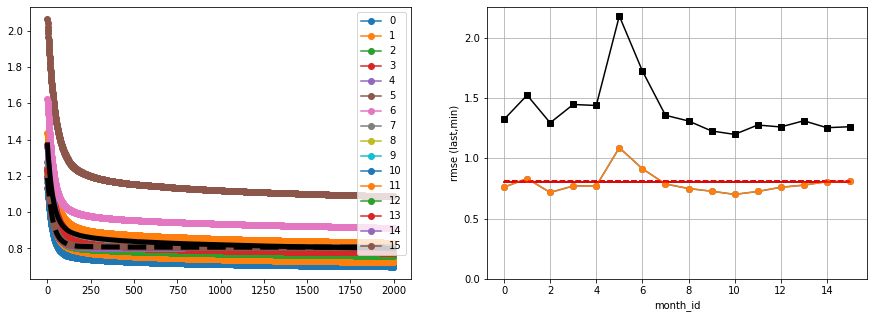

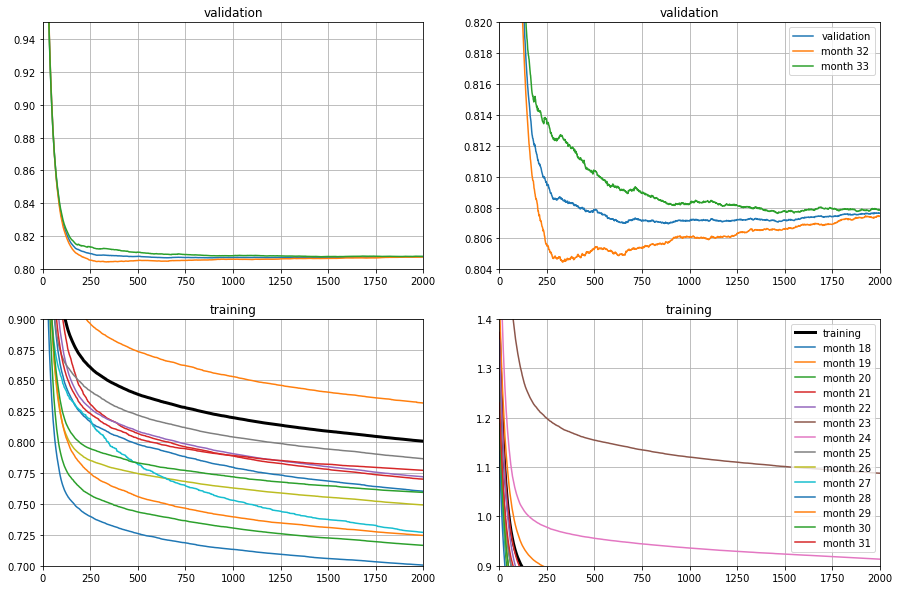

In [21]:
# PERFORMANCE ANALYSIS
performance_analysis_val(xgbreg,rmse_guess_train,rmse_base_train,rmse_guess_val,rmse_base_val,rmse_guess_evalset,rmse_base_evalset)

# learning curves
axes=learning_curves(xgbreg,n_months_val,month_id_first)

axes[0,0].set_ylim(0.8,0.95)
axes[0,1].set_ylim(0.804,0.82)
axes[1,0].set_ylim(0.7,0.9)
axes[1,1].set_ylim(0.9,1.4)

del axes

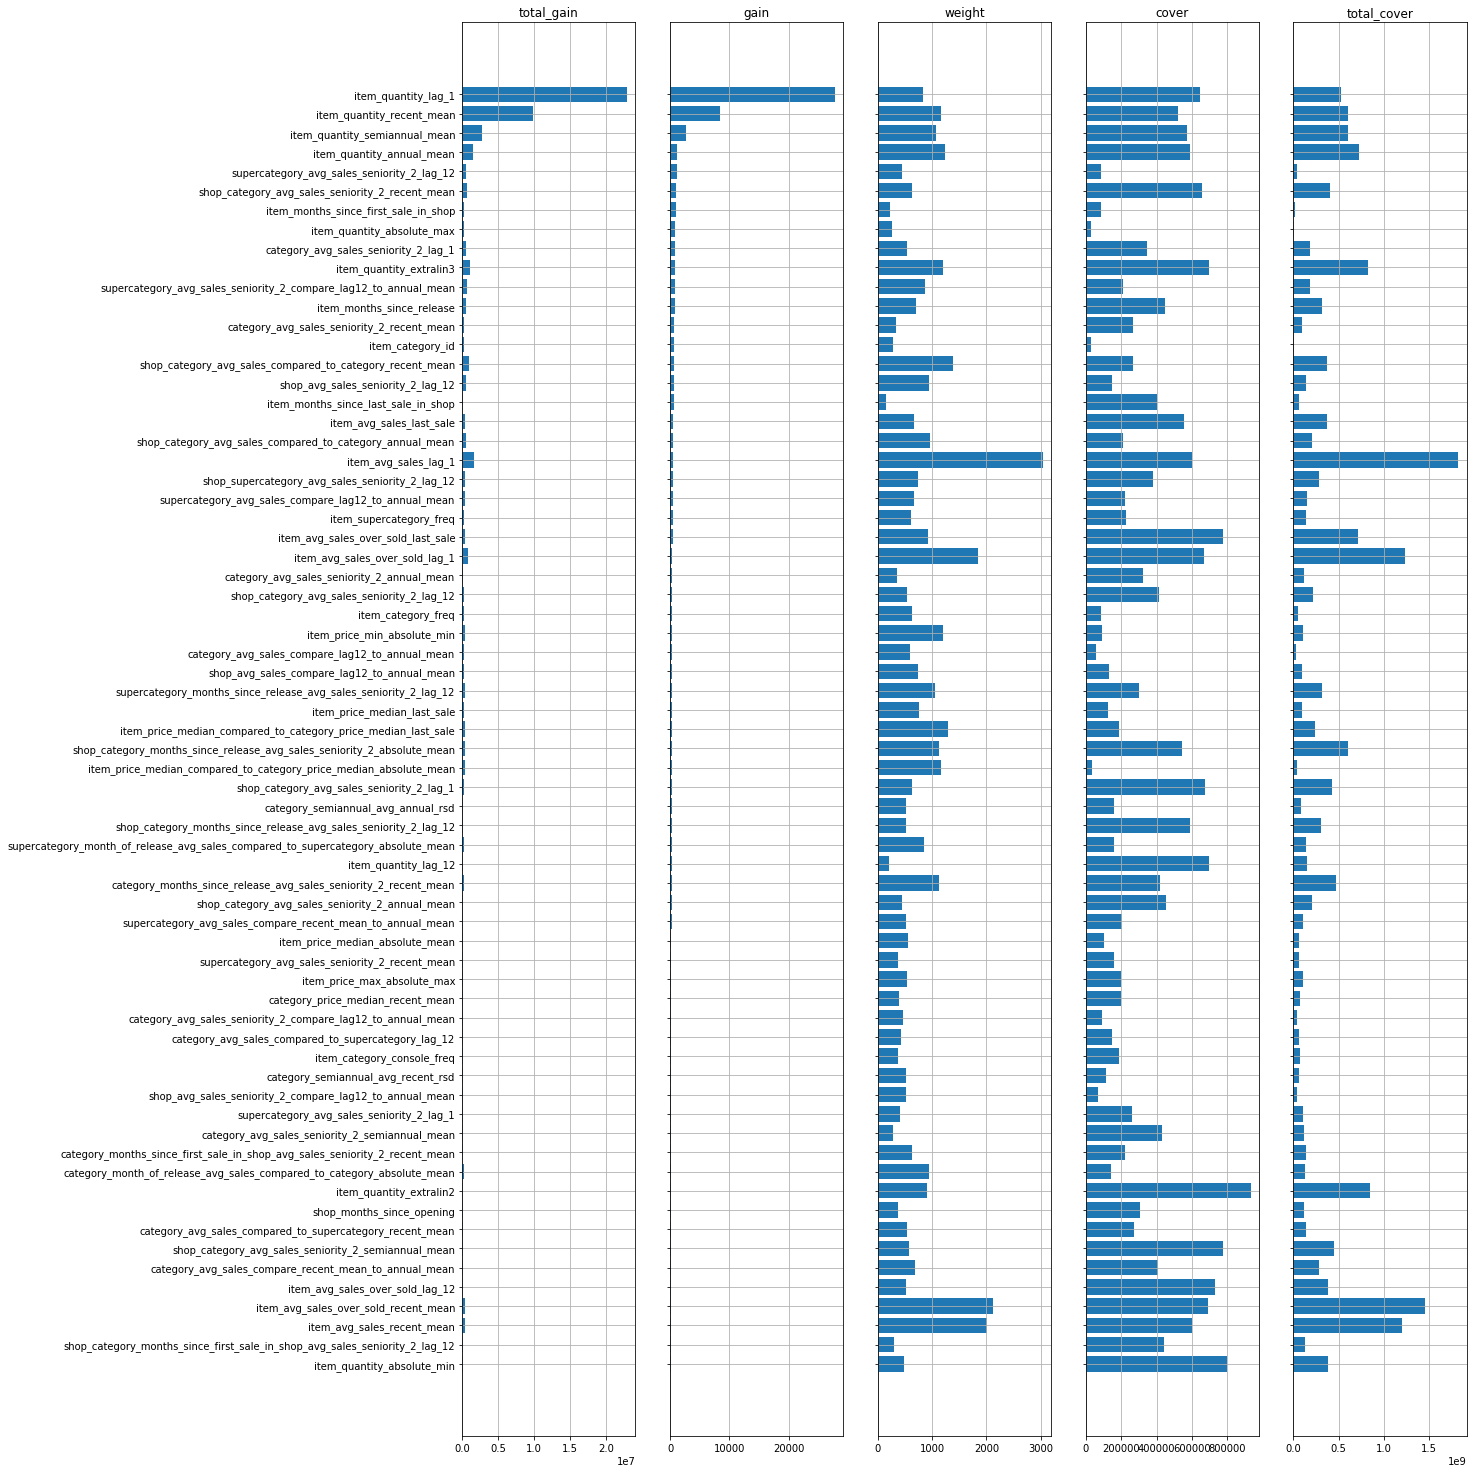

In [22]:
# FEATURE IMPORTANCE
plot_feature_importance(xgbreg,X_train)

In [23]:
# clear memory
del X_train, Y_train, X_val, Y_val
del eval_set
del rmse_guess_train, rmse_base_train, rmse_guess_val, rmse_base_val, rmse_guess_evalset, rmse_base_evalset
del xgbreg

gc.collect()

52630

In [24]:
reset_variable_space